In [107]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools

In [181]:
# Base Parameters
dt = 0.005 #time step
num_snaps = 2000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 200 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories
num_states = 2 # no. of states
num_inputs = 1 # no. of inputs

In [444]:
# Oscillator parameters
dyn_pars = {}

dyn_pars['a'] = 1
dyn_pars['b'] = 4
dyn_pars['c'] = 0.5
dyn_pars['d'] = 0.5
dyn_pars['del_a'] = 0
dyn_pars['del_b'] = 0
dyn_pars['del_c'] = 3
dyn_pars['del_d'] = 0
dyn_pars['delay'] = True
dyn_pars['delay_time'] = 3
dyn_pars['cont_unc_type'] = 'constant'

In [445]:
def dynamics_duff(dt, num_traj, num_snaps, num_inputs, dyn_pars):
    # Here the dyanmics will be missing one of the terms
    a = dyn_pars['a']
    b = dyn_pars['b']
    c = dyn_pars['c']
    d = dyn_pars['d']
    del_a = dyn_pars['del_a']
    del_b = dyn_pars['del_b']
    del_c = dyn_pars['del_c']
    del_d = dyn_pars['del_d']
    
    unc_type = dyn_pars['cont_unc_type']
    delay = dyn_pars['delay']
    delay_time = dyn_pars['delay_time']
    
    # data matricies for state and data
    X_cor = np.empty((num_traj,num_snaps+1,num_states))
    X_incor = np.empty((num_traj,num_snaps+1,num_states)) 
    U = np.empty((num_traj,num_snaps,num_inputs))
    
    for i in range(num_traj):
        # Initialize matrix for each trajectory
        
        # actual dynamics
        X_cor[i,0,0] = 2*np.random.rand(1) - 1    # E [-1,1]
        X_cor[i,0,1] = 0.5*(2*np.random.rand(1) - 1) #E[-0.5,0.5]
        
        # Incorrect dynamics
        X_incor[i,0,0] = X_cor[i,0,0]
        X_incor[i,0,1] = X_cor[i,0,1]
        
        for j in range(num_snaps):
            # actual dyanmic
            # x1_dot = x2 = 
            # x2_dot = -ax1 - bx1**3 - cu - dx2
            # for incomplete dynamics take out the x1 term
            U[i,j,:] = 0.5*(2*np.random.rand(1) - 1)
            
            if delay == True:
                if delay_time > dt*j:
                    amp_a = 0
                    amp_b = 0
                    amp_c = 0
                    amp_d = 0
                else:
                    amp_a = del_a
                    amp_b = del_b
                    amp_c = del_c
                    amp_d = del_d
            else:
                amp_a = del_a
                amp_b = del_b
                amp_c = del_c
                amp_d = del_d
            
            
            if unc_type == 'constant':
                amp_c = amp_c
            elif unc_type == 'sinosoidal':
                amp_c = amp_c*np.sin(0.25*np.pi*(j*dt))
            elif unc_type == 'none':
                amp_c = 0
            # dynamics update
            x2_dot_cor = -(a+amp_a)*X_cor[i,j,0] - (b+amp_b)*X_cor[i,j,0]**3 - (c+amp_c)*U[i,j,:] -(d+amp_d)*X_cor[i,j,1]
            x2_dot_incor = -a*X_incor[i,j,0] - b*X_incor[i,j,0]**3 - c*U[i,j,:] - d*X_incor[i,j,1]
            
            # State update
            X_cor[i,j+1,1] = X_cor[i,j,1] + x2_dot_cor*dt
            X_cor[i,j+1,0] = X_cor[i,j,0] + X_cor[i,j,1]*dt + (1/2)*x2_dot_cor*dt**2
            
            X_incor[i,j+1,1] = X_incor[i,j,1] + x2_dot_incor*dt
            X_incor[i,j+1,0] = X_incor[i,j,0] + X_incor[i,j,1]*dt + (1/2)*x2_dot_incor*dt**2
            
            
    return X_cor, X_incor,U       

In [446]:
X_cor, X_incor, U = dynamics_duff(dt, num_traj, num_snaps, num_inputs, dyn_pars)

print(X_cor.shape, U.shape)

(250, 2001, 2) (250, 2000, 1)


In [447]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_cor)))))
print(sum(sum(sum(np.isnan(X_incor)))))

0
0


In [448]:
l2_diff = np.linalg.norm(X_cor-X_incor)/((X_cor.size)**(1/2))
print('l2_diff = ', l2_diff)

l2_diff =  0.042042939179473764


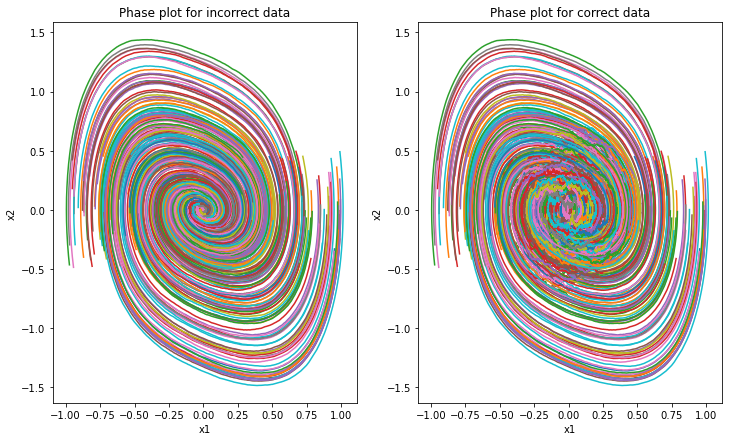

In [449]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for incorrect data")
axs[1].set_title("Phase plot for correct data")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_incor[i,:,0], X_incor[i,:,1])
    axs[1].plot(X_cor[i,:,0], X_cor[i,:,1])
plt.savefig('phase_plot_duffing.jpg')

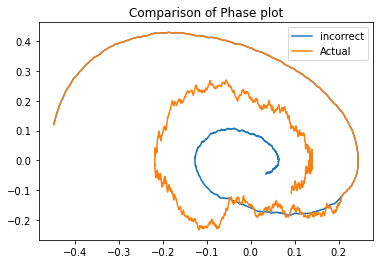

In [450]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_incor[4,:,0], X_incor[4,:,1], label = 'incorrect')
plt.plot(X_cor[4,:,0], X_cor[4,:,1], label = 'Actual')

plt.legend()
plt.savefig('phase_plot_duffing_sigle_traj.jpg')
plt.show()


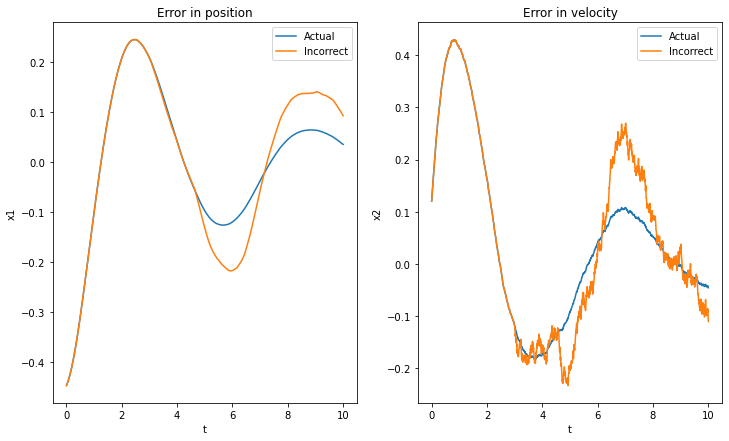

In [451]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in position")
axs[1].set_title("Error in velocity")

axs[0].set(xlabel = 't', ylabel = 'x1')
axs[1].set(xlabel = 't', ylabel = 'x2')


axs[0].plot(T, X_incor[4,:,0], label = 'Actual')
axs[0].plot(T, X_cor[4,:,0], label = 'Incorrect')
axs[0].legend()

axs[1].plot(T, X_incor[4,:,1], label = 'Actual')
axs[1].plot(T, X_cor[4,:,1], label = 'Incorrect')
axs[1].legend()

plt.savefig('vel_pos_err_duffing_sigle_traj.jpg')

In [452]:
# split training and vaidation datasets
xs_train, us_train = X_incor[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_incor[num_train:,:,:],U[num_train:,:,:]

***Classes for Koopman bilinear Models***

In [453]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

# base class for koopman net

class KoopmanNet(nn.Module):
  def __init__(self, net_params, standardizer_x=None, standardizer_u=None):
    super(KoopmanNet, self).__init__()
    self.net_params = net_params
    self.standardizer_x = standardizer_x
    self.standardizer_u = standardizer_u
    self.encoder = None
    self.opt_parameter_encoder = []
    self.opt_parameters_dyn_mats = []
    self.x_running_mean = None
    self.x_running_var = None


  def construct_net(self):
    pass
  
  def forward(self, data):
    pass

  def process(self, data_x, data_u=None, downsample_rate = 1):
    pass
  
  def construct_dyn_mat(self):
    pass

  def loss(self, outputs, labels):
    n = self.net_params['state_dim']
    n_z = self.net_params['encoder_output_dim']
    override_C = self.net_params['override_C']
    
    #output = x_proj, x_prime_diff_pred, z_prime_diff_pred, z_prime_diff
    #ilabels =  [x,x_prime_diff]

    # next time step pred
    x_proj = outputs[:,:n]
    x = labels[:,:n]
    
    x_prime_diff_pred = outputs[:,n:2*n]
    x_prime_diff = labels[:, n:2*n]

    # next time step pred diff in lifted space
    z_prime_diff_pred = outputs[:, 2*n:2*n+n_z]
    z_prime_diff = outputs[:,2*n+n_z : 2*n+2*n_z]

    # l1 regularization
    alpha = self.net_params['lifted_loss_penalty']
    # criterion
    criterion = nn.MSELoss()

    #pred_loss = criterion(x_prime_pred,x_prime)
    if override_C:
        pred_loss = criterion(x_prime_diff_pred,torch.divide(x_prime_diff,self.loss_scaler_x[:n]))
    else:
        pred_loss = criterion(x_prime_diff_pred,x_prime_diff/self.loss_scaler_z)
        

    #proj_loss = reconstruction loss
    proj_loss = criterion(x_proj, x)

    #lifted state loss
    lifted_loss = criterion(z_prime_diff_pred, z_prime_diff/self.loss_scaler_z)/(n_z/n)
    l1_loss = 0.
    # l1 regulaization
    if 'l1_reg' in self.net_params and self.net_params['l1_reg'] > 0:
      l1_reg = self.net_params['l1_reg']
      l1_loss = l1_reg*self.get_l1_norm_()

    if override_C:
        total_loss = pred_loss + alpha*lifted_loss + l1_loss
    else:
        total_loss = proj_loss + pred_loss + alpha*lifted_loss + l1_loss
    return total_loss, pred_loss, alpha*lifted_loss

  # construct the autoencoder part
  def construct_encoder_(self):
    input_dim = self.net_params['state_dim']
    hidden_depth = self.net_params['encoder_hidden_depth']
    hidden_width = self.net_params['encoder_hidden_width']
    output_dim = self.net_params['encoder_output_dim']
    activation_type = self.net_params['activation_type']

    if hidden_depth > 0:
      # input layer
      self.encoder_fc_in = nn.Linear(input_dim,hidden_width)
      self.opt_parameter_encoder.append(self.encoder_fc_in.weight)
      self.opt_parameter_encoder.append(self.encoder_fc_in.bias)
      #the hidden laers will be passed as list elements to this module
      self.encoder_fc_hid = nn.ModuleList()

      # hidden layers
      for i in range(1, hidden_depth):
        self.encoder_fc_hid.append(nn.Linear(hidden_width,hidden_width))
        self.opt_parameter_encoder.append(self.encoder_fc_hid[-1].weight)
        self.opt_parameter_encoder.append(self.encoder_fc_hid[-1].bias)
    
      self.encoder_fc_out = nn.Linear(hidden_width,output_dim)
      self.opt_parameter_encoder.append(self.encoder_fc_out.weight)
      self.opt_parameter_encoder.append(self.encoder_fc_out.bias)
    
    #output layers
    else: # no hidden layers
      self.encoder_fc_out = nn.Linear(input_dim,output_dim)
      self.opt_parameter_encoder.append(self.encoder_fc_out.weight)
      self.opt_parameter_encoder.append(self.encoder_fc_out.bias)
    

    # activation functions
    if activation_type == 'relu':
      self.activation_fcn = F.relu

    if activation_type == 'elu':
      self.activation_fcn = nn.relu

    if activation_type == 'tanh':
      self.activation_fcn = torch.tanh

    if activation_type == 'sigmoid':
      self.activation_fcn = torch.sigmoid

    else:
      exit("Exit : invalid activation function")

  def encode_forward_(self,x): #encoder_forward_pass
    if self.net_params['encoder_hidden_depth'] > 0:
      x = self.activation_fcn(self.encoder_fc_in(x))
      
      for layer in self.encoder_fc_hid:
        x = self.activation_fcn(layer(x))
    
    x = self.encoder_fc_out(x)

    return x

  def encode(self, x):
    first_obs_const = int(self.net_params['first_obs_const'])
    n = self.net_params['state_dim']
    override_C = self.net_params['override_C']
    x_t = torch.from_numpy(x).float
    if override_C:
        z = np.concatenate((np.ones((x.shape[0], first_obs_const)), x[:, :n], self.encode_forward_(x_t).detach().numpy()), axis=1)
    else:
        z = np.concatenate((np.ones((x.shape[0], first_obs_const)), self.encode_forward_(x_t).detach().numpy()),  axis=1)
    return z
  
  def preprocess_data(self, data, standardizer):
    if standardizer is None:
      data_scaled = data
    else:
      data_scaled = np.array([standardizer.transform(d) for d in data])

    return data_scaled


In [454]:
# class for koopman net with control

class KoopmanNetCtrl(KoopmanNet):
    def __init__(self, net_params,standardizer_x=None, standardizer_u=None):
        super(KoopmanNetCtrl, self).__init__(net_params,standardizer_x=standardizer_x, standardizer_u=standardizer_u)

      # define a function to contruct net
    def construct_net(self):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        encoder_output_dim = self.net_params['encoder_output_dim']
        # include constants in lifted states
        first_obs_const = self.net_params['first_obs_const'] #only one state
        override_C = self.net_params['override_C']
        # total no of lifted staes = states+constants+encoder output
        if override_C:
            self.n_tot = int(first_obs_const) + encoder_output_dim + n
        else:
            self.n_tot = int(first_obs_const) + encoder_output_dim

        self.construct_encoder_()
        # create the linear layer to move the states one step ahead
        # for drift
        self.koopman_fc_drift = nn.Linear(self.n_tot, self.n_tot-first_obs_const, bias = False)
        # actuation
        self.koopman_fc_act = nn.Linear(m*self.n_tot, self.n_tot-first_obs_const, bias = False)

        # get a fully connected layer to get back x
        if override_C:
            self.C = torch.cat((torch.zeros((n, first_obs_const)), torch.eye(n),torch.zeros((n, encoder_output_dim))), 1)
        else:
            self.projection_fc = nn.Linear(self.n_tot, n, bias = False)

    def forward(self, data):
        # data = [x, u, x_prime]
        #output = [x_proj,x_prime_pred, z_prime_pred, z_prime]
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        # include constants in lifted states
        first_obs_const = int(self.net_params['first_obs_const']) #only one state
        override_C = self.net_params['override_C'] 

        x = data[:, :n]
        u = data[:, n:n+m]
        x_prime = data[:,n+m:]

        # define the lifted states
        if override_C:
            z = torch.cat((torch.ones((x.shape[0], first_obs_const)),x[:,:n],self.encode_forward_(x)),1)
            z_prime_diff = self.encode_forward_(x_prime) - z[:,first_obs_const+n:]
        else:
            z = torch.cat((torch.ones((x.shape[0], first_obs_const)),self.encode_forward_(x)),1)
            z_prime_diff = self.encode_forward_(x_prime) - z[:,first_obs_const:]
            
        # bilinear states
        z_u = torch.cat([torch.transpose(torch.mul(torch.transpose(z, 0, 1), u_i), 0, 1) for u_i in torch.transpose(u, 0, 1)], 1)
        drift_matrix, act_matrix = self.construct_drift_act_matrix_()
        # predicted z_prime_diff
        #z_(k+1) - z_(k) = drift_fun(z_k) + act_fun(z_k*u_k) 
        z_prime_diff_pred = torch.matmul(z, torch.transpose(drift_matrix, 0, 1)) + torch.matmul(z_u, torch.transpose(act_matrix, 0, 1))

        # x_projected
        if override_C:
            x_proj = torch.matmul(z, torch.transpose(self.C,0,1))
            x_prime_diff_pred = torch.matmul(z_prime_diff_pred, torch.transpose(self.C,0,1))
            z_prime_diff_pred = z_prime_diff_pred[:,first_obs_const+n:]
        else:
            x_proj = self.projection_fc(z) 
            x_prime_diff_pred = self.projection_fc(z_prime_diff_pred)
            z_prime_diff_pred = z_prime_diff_pred[:,first_obs_const:]

        return torch.cat((x_proj, x_prime_diff_pred, z_prime_diff_pred, z_prime_diff),1)

    def construct_drift_act_matrix_(self): 
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        const_obs_dyn_drift = torch.zeros((first_obs_const, self.n_tot)) # drift for the constant term
        drift_matrix = torch.cat((const_obs_dyn_drift, self.koopman_fc_drift.weight), 0)
        #drift_matrix = self.koopman_fc_drift.weight
        const_obs_dyn_act = torch.zeros((first_obs_const, m*self.n_tot)) # actuation for the constant term
        act_matrix = torch.cat((const_obs_dyn_act, self.koopman_fc_act.weight), 0)
        #act_matrix = self.koopman_fc_act.weight


        return drift_matrix, act_matrix

    def process(self, data_x, data_u = None, downsample_rate = 1, train_mode =True):
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        n_traj = data_x.shape[0]

        data_scaled_x = self.preprocess_data(data_x, self.standardizer_x)
        data_scaled_u = self.preprocess_data(data_u, self.standardizer_u)

        #data_scaled_x = data_x
        #data_scaled_u = data_u

        x = data_scaled_x[:, :-1, :]
        u = data_scaled_u
        x_prime = data_scaled_x[:,1:,:]

        order = 'F'
        n_data_pts = n_traj * (x.shape[1])
        x_flat = x.T.reshape((n, n_data_pts), order=order)
        u_flat = u.T.reshape((m, n_data_pts), order=order)
        x_prime_flat = x_prime.T.reshape((n, n_data_pts), order=order)

        X = np.concatenate((x_flat.T, u_flat.T, x_prime_flat.T), axis=1)
        #y = x_prime_flat.T
        y = np.concatenate((x_flat.T, x_prime_flat.T-x_flat.T), axis=1)

        if train_mode:
            self.loss_scaler_x = torch.Tensor(np.std(x_prime_flat[:n, :].T - x_flat[:n, :].T, axis=0))
            self.loss_scaler_z = np.std(x_prime_flat.T - x_flat.T)

        return X[::downsample_rate,:], y[::downsample_rate,:]


    def construct_dyn_mat(self): # take a look again
        n = self.net_params['state_dim']
        m = self.net_params['ctrl_dim']
        encoder_output_dim = self.net_params['encoder_output_dim']
        first_obs_const = int(self.net_params['first_obs_const'])
        override_C = self.net_params['override_C']
        if override_C:
            loss_scaler = np.concatenate((np.ones(first_obs_const), self.loss_scaler_x.numpy(), self.loss_scaler_z*np.ones(encoder_output_dim)))
        else:
            loss_scaler = np.concatenate((np.ones(first_obs_const), self.loss_scaler_z * np.ones(encoder_output_dim)))
        drift_matrix, act_matrix = self.construct_drift_act_matrix_()

        self.A = drift_matrix.data.numpy()
        self.A[first_obs_const:, :] = np.multiply(self.A[first_obs_const:, :],loss_scaler[first_obs_const:].reshape(-1, 1))
        self.A += np.eye(self.n_tot)

        #B_vec = act_matrix.data.numpy()
        #self.B = [np.multiply(B_vec[:, self.n_tot * ii:self.n_tot * (ii + 1)], loss_scaler.reshape(-1,1)) for ii in range(m)]
        self.B = act_matrix.data.numpy()
        for ii in range(m):
            self.B[:, self.n_tot * ii:self.n_tot * (ii + 1)] = np.multiply(self.B[:, self.n_tot * ii:self.n_tot * (ii + 1)], loss_scaler.reshape(-1,1))
        
        if not override_C:
            self.C = self.projection_fc.weight.detach().numpy()

    def get_l1_norm_(self):
          return torch.norm(self.koopman_fc_drift.weight.view(-1), p=1) + torch.norm(self.koopman_fc_act.weight.view(-1), p=1)

In [455]:
import torch.optim as optim
from torch.utils.data import random_split
import os
class KoopDNN():
  "class for nn based learning"
  def __init__(self, net, first_obs_const=True, dt = None):
    self.A = None
    self.B = None

    self.net = net
    self.optimizer = None
    self.C = None

    self.first_obs_const = first_obs_const
    self.dt = dt

    self.x_train = None
    self.u_train = None
    self.x_val = None
    self.u_val = None

  def set_datasets(self, x_train, u_train=None, x_val=None, u_val=None):
    self.x_train = x_train
    self.u_train = u_train

    self.x_val = x_val
    self.u_val = u_val

  def model_pipeline(self, net_params, print_epoch = True,early_stop=False, plot_data = False):
    self.net.net_params = net_params
    self.net.construct_net()
    self.set_optimizer_()

    X_train, y_train = self.net.process(self.x_train, data_u=self.u_train)
    X_val, y_val = self.net.process(self.x_val, data_u=self.u_val, train_mode=False)
    
    if plot_data:
      self.plot_train_data(X_train, y_train)

    X_train_t, y_train_t = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
    X_val_t, y_val_t = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
    dataset_train = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    dataset_val = torch.utils.data.TensorDataset(X_val_t, y_val_t)

    self.train_model(dataset_train, dataset_val, print_epoch=print_epoch)

  def train_model(self, dataset_train, dataset_val, print_epoch = True, tune_run = False, early_stop = False,early_stop_crit=1e-3, early_stop_max_count=5,):
    trainloader = torch.utils.data.DataLoader(dataset_train, batch_size = self.net.net_params['batch_size'], shuffle = True)
    valloader = torch.utils.data.DataLoader(dataset_val, batch_size = self.net.net_params['batch_size'])

    val_loss_prev = np.inf
    no_improv_counter = 0
    self.train_loss_hist = []
    self.val_loss_hist = []
    for epoch in range(self.net.net_params['epochs']):
      running_loss = 0.0
      running_pred_loss = 0.0
      running_lifted_loss = 0.0
      epoch_steps = 0

      for data in trainloader:
        inputs, labels = data

        self.optimizer.zero_grad()
        output =self.net(inputs)
        loss, pred_loss, lifted_loss = self.net.loss(output, labels)
        loss.backward()
        self.optimizer.step()

        running_loss += loss.detach()
        running_pred_loss += pred_loss.detach()
        running_lifted_loss += lifted_loss.detach()
        epoch_steps += 1

      val_loss = 0.0
      val_pred_loss = 0.0
      val_lifted_loss = 0.0
      val_steps =0

      for data in valloader:
        with torch.no_grad():
          inputs, labels = data

          output = self.net(inputs)
          loss, pred_loss, lifted_loss = self.net.loss(output, labels)

          val_loss += float(loss.detach())
          val_pred_loss += float(pred_loss.detach())
          val_lifted_loss += float(lifted_loss.detach())
          val_steps += 1
  
  # Print epoch loss
      self.train_loss_hist.append((running_loss/epoch_steps, running_pred_loss/epoch_steps, running_lifted_loss/epoch_steps))
      self.val_loss_hist.append((val_loss/val_steps, val_pred_loss/val_steps, val_lifted_loss/val_steps))
      if print_epoch:
          print('Epoch %3d: train loss: %.10f, validation loss: %.10f' %(epoch + 1, self.train_loss_hist[-1][0], self.val_loss_hist[-1][0]))

      if early_stop:
        improvement = (val_loss/val_steps)/val_loss_prev
        if improvement >= 1 - early_stop_crit and improvement <= 1+early_stop_crit:
            no_improv_counter += 1
        else:
            no_improv_counter = 0

        if no_improv_counter >= early_stop_max_count:
            print('Early stopping activated, less than %.4f improvement for the last %2d epochs.'%(early_stop_crit, no_improv_counter))
            break
        val_loss_prev = val_loss/val_steps

    print("Finished Training")

  def test_loss(self, x_test, u_test = None):
    if u_test is None:
      X_test, y_test = self.net.process(x_test, train_model = False)
    else:
      X_test, y_test = self.net.process(x_test, data_u = u_test, train_mode = False)
    
    X_t, y_t = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
    dataset_test = torch.utils.data.TensorDataset(X_t, y_t)
    testloader = torch.utils.data.DataLoader(dataset_test, batch_size=self.net.net_params['batch_size'], shuffle=True)

    test_loss = 0.0
    test_steps = 0
    with torch.no_grad():
      for data in testloader:
        inputs, labels = data

        outputs = self.net(inputs)
        loss, _, _ = self.net.loss(outputs, labels)
        test_loss += loss.detach()
        test_steps += 1

    return test_loss/test_steps
  
  def construct_koopman_model(self):
      self.construct_dyn_mat_()

  def construct_dyn_mat_(self):
      self.net.construct_dyn_mat()
      self.A = self.net.A
      try:
        self.B = self.net.B
      except AttributeError:
        pass
      self.C = self.net.C

  def basis_encode(self, x):
      if self.net.standardizer_x is None:
        x_scaled = np.atleast_2d(x)
      else:
        x_scaled = self.net.standardizer_x.transform(x)

      return self.net.encode(x_scaled)

  def set_optimizer_(self):
    if self.net.net_params['optimizer'] == 'sgd':
        lr = self.net.net_params['lr']
        momentum = self.net.net_params['momentum']
        self.optimizer_encoder = optim.SGD(self.net.opt_parameters_encoder, lr=lr, momentum=momentum)
        self.optimizer_dyn_mats = optim.SGD(self.net.opt_parameters_dyn_mats, lr=lr, momentum=momentum)
    elif self.net.net_params['optimizer'] == 'adam':
        lr = self.net.net_params['lr']
        weight_decay = self.net.net_params['l2_reg']
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)
    elif self.net.net_params['optimizer'] == 'adamax':
        lr = self.net.net_params['lr']
        weight_decay = self.net.net_params['l2_reg']
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)

  # plotting methods

  def plot_train_data(self, X,y):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(121, projection = '3d')
    ax.scatter(X[:, 2], X[:, 3], y[:, 2], color="orange")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel("$x_1'$")
    ax.set_title('One-step-ahead state, $x_1$')
    ax.view_init(30, 70)

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X[:, 2], X[:, 3], y[:, 3], color="orange")
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel("$x_2'$")
    ax.set_title('One-step-ahead state, $x_2$')
    ax.view_init(30, 70)
    plt.show()

  def plot_learning_curve(self):
    import matplotlib.pyplot as plt

    train_loss = np.array(self.train_loss_hist)  # [[total loss, prediction loss, bilinearity loss]]
    val_loss = np.array(self.val_loss_hist)  # [[total loss, prediction loss, bilinearity loss]]
    iter = np.arange(train_loss.shape[0])
    titles = ['Total loss', 'Prediction loss', 'Bilinearity loss']
    plt.figure(figsize=(16,5))
    for ii in range(3):
      plt.subplot(1,3,ii+1)
      plt.plot(iter, train_loss[:, ii], label='training')
      plt.plot(iter, val_loss[:, ii], '--', label='validation')
      plt.title(titles[ii])
      if ii == 2:
          plt.legend()
      plt.show()

In [456]:
# auto encoder parameters

net_params = {}
net_params['state_dim'] = num_states
net_params['ctrl_dim'] = num_inputs
net_params['encoder_hidden_width'] = 30
net_params['encoder_hidden_depth'] = 2
net_params['encoder_output_dim'] = 15
net_params['optimizer'] = 'adam'
net_params['activation_type'] = 'tanh'
net_params['lr'] = 5e-4 # 5e-4
net_params['epochs'] = 1000
net_params['batch_size'] = 256
net_params['lifted_loss_penalty'] = 0.3
net_params['l2_reg'] = 0.0         
net_params['l1_reg'] = 0.0
net_params['first_obs_const'] = True
net_params['override_C'] = True # this makes the state a part of lifted state
net_params['dt'] = dt

In [457]:
train = False

if train == True:
    file = 'duff.pth'
    net = KoopmanNetCtrl(net_params)
    model_koop_dnn = KoopDNN(net)
    model_koop_dnn.set_datasets(xs_train, u_train=us_train, x_val=xs_val, u_val=us_val)
    model_koop_dnn.model_pipeline(net_params)
    model_koop_dnn.construct_koopman_model()
    torch.save(model_koop_dnn,file)
else:
    file = 'duff_best_cont.pth'
    model_koop_dnn = torch.load(file)

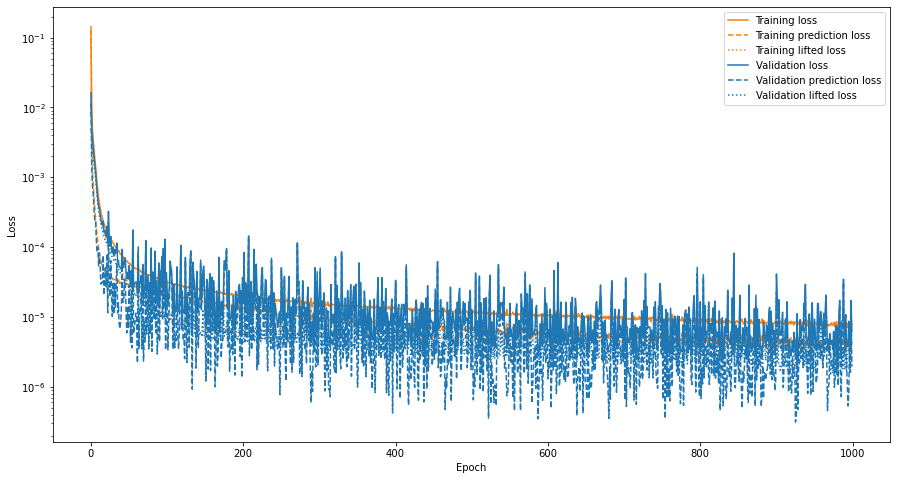

In [458]:
train_loss = [l[0] for l in model_koop_dnn.train_loss_hist]
train_pred_loss = [l[1] for l in model_koop_dnn.train_loss_hist]
train_lifted_loss = [l[2] for l in model_koop_dnn.train_loss_hist]
val_loss = [l[0] for l in model_koop_dnn.val_loss_hist]
val_pred_loss = [l[1] for l in model_koop_dnn.val_loss_hist]
val_lifted_loss = [l[2] for l in model_koop_dnn.val_loss_hist]
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_loss, color='tab:orange', label='Training loss')
plt.plot(epochs, train_pred_loss, '--', color='tab:orange', label='Training prediction loss')
plt.plot(epochs, train_lifted_loss, ':', color='tab:orange', label='Training lifted loss')
plt.plot(epochs, val_loss, color='tab:blue', label='Validation loss')
plt.plot(epochs, val_pred_loss, '--', color='tab:blue', label='Validation prediction loss')
plt.plot(epochs, val_lifted_loss, ':', color='tab:blue', label='Validation lifted loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

# Learned Model Parameters

## Bilinear Model Parameters

In [459]:
A = np.array(model_koop_dnn.A)
#B = np.array(model_koop_dnn.B).reshape(-1,num_inputs*n_obs)
B = np.array(model_koop_dnn.B)
#B_tensor = np.empty((num_inputs,n_obs, n_obs))
#for ii, b in enumerate(B):
    #B_tensor[ii] = b
C = np.array(model_koop_dnn.C)

print(A.shape, B.shape, C.shape)

(18, 18) (18, 18) (2, 18)


## Lifting function

In [460]:
def lift(x,model_koop_dnn, first_obs_const, override_C):
    if first_obs_const == 1:
        if override_C:
            Z = np.concatenate((np.ones((1,)),x,model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy()))
        else:
            Z = np.concatenate((np.ones((1,)),model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy()))
    else:
        if override_C:
            Z = np.concatenate((x,model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy()))
        else:
            Z = (model_koop_dnn.net.encode_forward_(torch.from_numpy(x).float()).detach().numpy())
    return Z

# Testing

## Parameters

In [461]:
# test data parameters
num_snaps_test = 2000 # no. of snapshots
T_test = np.linspace(0,num_snaps_test*dt, num_snaps_test+1)
num_traj_test = 1 # no. of training examples
first_obs_const = int(net_params['first_obs_const']) #only one state
override_C = net_params['override_C']
if override_C:
    n_obs = int(net_params['encoder_output_dim']) + num_states + first_obs_const 
else:
    n_obs = int(net_params['encoder_output_dim']) + first_obs_const 

## Testing Data

In [462]:
x_cor_test, x_incor_test, u_test = dynamics_duff(dt, num_traj_test, num_snaps_test, num_inputs, dyn_pars)
print(model_koop_dnn.test_loss(x_incor_test,u_test = u_test))

tensor(3.2525e-06)


In [463]:
x_cor_test.shape

(1, 2001, 2)

In [464]:
# Use the preprocessing if available
X_incor,_ = model_koop_dnn.net.process(x_incor_test,data_u = u_test)
X_cor,_ = model_koop_dnn.net.process(x_cor_test,data_u = u_test)

In [465]:
X_cor.shape

(2000, 5)

In [466]:
# flatten vector
x_incor = X_incor[:, :num_states]
u = X_incor[:, num_states:num_states+num_inputs]
x_incor_prime = X_incor[:,num_states+num_inputs:]

x_cor = X_cor[:, :num_states]
x_cor_prime = X_cor[:,num_states+num_inputs:]

x_cor_dot = (x_cor_prime-x_cor)/dt
print(x_cor.shape, u.shape, x_cor_prime.shape)

(2000, 2) (2000, 1) (2000, 2)


# Lifting of states

In [467]:
# initialize states
# initialize the matricies
z_incor = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
x_incor_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values

In [468]:
# actual lift
z_incor[0,:] = lift(x_incor[0,:],model_koop_dnn, first_obs_const, override_C)
x_incor_est[0,:] = x_incor[0,:]

# Time Evolution

In [469]:
for i in range(num_snaps_test):
  #bilinear
    z_incor[i+1,:] = np.matmul(z_incor[i,:],A.T)+np.matmul(np.kron(u[i,:],z_incor[i,:]),B.T)
    x_incor_est[i+1,:] = np.matmul(z_incor[i+1,:],C.T) 

# Plotting

## Lifting performance

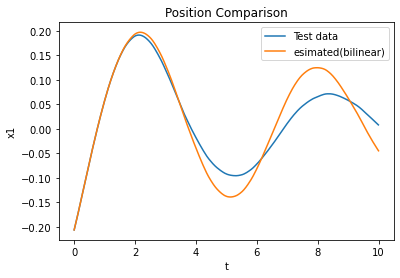

In [470]:
plt.figure()
plt.plot(T_test[:-1],x_incor[:,0],label ='Test data')
plt.plot(T_test,x_incor_est[:,0],label = 'esimated(bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()

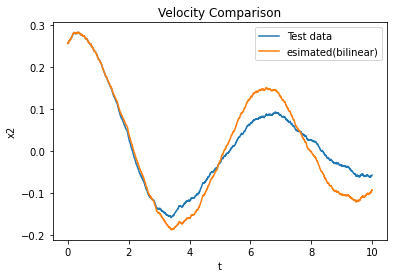

In [471]:
plt.figure()
plt.plot(T_test[:-1],x_incor[:,1],label ='Test data')
plt.plot(T_test,x_incor_est[:,1],label = 'esimated(bilinear)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()

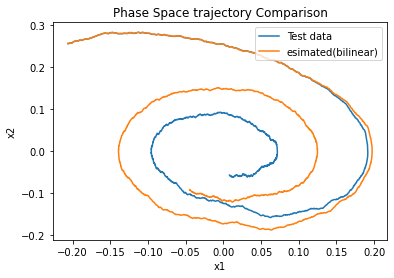

In [472]:
plt.figure()
plt.plot(x_incor[:,0],x_incor[:,1],label ='Test data')
plt.plot(x_incor_est[:,0],x_incor_est[:,1],label = 'esimated(bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()

### Error Evolution

In [489]:
error_model = np.sqrt(np.square(x_incor_est[:-1,:]-x_incor[:,:]).mean(axis=1))
error_dynamics = np.sqrt(np.square(x_incor_est[:-1,:]-x_cor[:,:]).mean(axis=1))

Text(0.5, 1.0, 'Model error evolution')

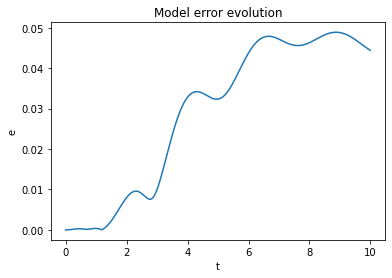

In [490]:
plt.figure()
plt.plot(T_test[:-1],error_model)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Model error evolution')

## Deviation from Actual Dynamics

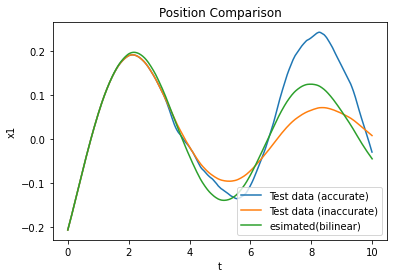

In [491]:
plt.figure()
plt.plot(T_test[:-1],x_cor[:,0],label ='Test data (accurate)')
plt.plot(T_test[:-1],x_incor[:,0],label ='Test data (inaccurate)')
plt.plot(T_test,x_incor_est[:,0],label = 'esimated(bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()

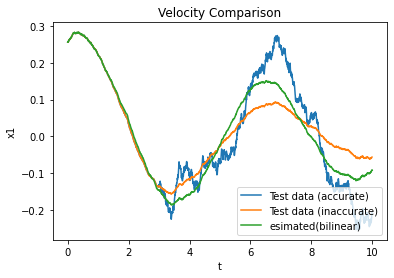

In [492]:
plt.figure()
plt.plot(T_test[:-1],x_cor[:,1],label ='Test data (accurate)')
plt.plot(T_test[:-1],x_incor[:,1],label ='Test data (inaccurate)')
plt.plot(T_test,x_incor_est[:,1],label = 'esimated(bilinear)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Velocity Comparison')
plt.legend()

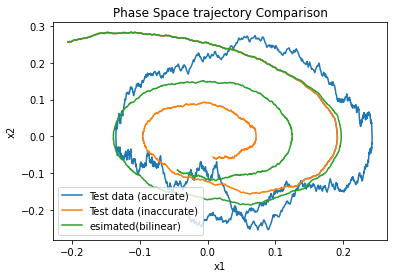

In [493]:
plt.figure()
plt.plot(x_cor[:,0],x_cor[:,1],label ='Test data (accurate)')
plt.plot(x_incor[:,0],x_incor[:,1],label ='Test data (inaccurate)')
plt.plot(x_incor_est[:,0],x_incor_est[:,1],label = 'esimated(bilinear)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Phase Space trajectory Comparison')
plt.legend()

Text(0.5, 1.0, 'Dynamics error evolution')

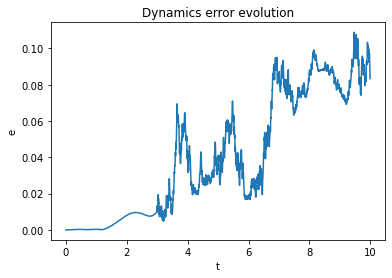

In [494]:
plt.figure()
plt.plot(T_test[:-1],error_dynamics)
plt.xlabel('t')
plt.ylabel('e')
plt.title('Dynamics error evolution')

# Adaptation

## Data Preprocessing

In [495]:
# initialize state matricies
z_adap = np.empty((n_obs,num_snaps_test+1)).T   #lifted state
z_cor = np.empty((n_obs,num_snaps_test)).T #actual lifted state
del_z_prime = np.empty((n_obs,num_snaps_test)).T
zu_incor = np.empty((n_obs*num_inputs,num_snaps_test)).T  
x_adap_est = np.zeros((num_states,num_snaps_test+1)).T #estimated values
del_A_norm = np.zeros((num_snaps_test,1))
del_B_norm = np.zeros((num_snaps_test,1))
# initialize
z_adap[0,:] = z_incor[0,:]
zu_incor[0,:] = np.kron(u[0,:],z_incor[i,:])
x_adap_est[0,:] = x_incor[0,:]

#
adap_window = 10
adap_factor = 6e-1

# Adaptive Time evolution

In [496]:
for i in range(num_snaps_test):
  # incorrect dynamics
    zu_incor[i,:] = np.kron(u[i,:],z_adap[i,:])
    z_incor[i+1,:] = np.matmul(z_adap[i,:],A.T)+np.matmul(zu_incor[i,:],B.T)
    
    z_cor[i,:] = lift(x_cor[i,:],model_koop_dnn, first_obs_const, override_C)
    
    del_z_prime[i,:] = z_cor[i,:] - z_incor[i,:]
    if i < adap_window + 1 :
        del_A = np.zeros_like(A)
        del_B = np.zeros_like(A)
    else:
        del_Z_prime = del_z_prime[i-adap_window:i,:].T
        Z_incor = z_incor[i-(adap_window+1):i-1].T  
        ZU_incor = zu_incor[i-(adap_window+1):i-1].T
        Omega = np.vstack((Z_incor, ZU_incor))
        G = np.matmul(del_Z_prime, np.linalg.pinv(Omega))
        del_A = G[0:n_obs,0:n_obs]
        del_B = G[0:n_obs,n_obs:n_obs*(num_inputs+1)]

    del_A_norm[i] = np.linalg.norm(del_A)
    del_B_norm[i] = np.linalg.norm(del_B)
    
    if del_B_norm[i] < np.linalg.norm(B):
        B_factor = adap_factor
    else:
        B_factor = adap_factor*np.linalg.norm(B)/del_B_norm[i]
    
    if del_A_norm[i] < np.linalg.norm(A):
        A_factor = adap_factor
    else:
        A_factor = adap_factor*np.linalg.norm(A)/del_A_norm[i]
        
    del_A = A_factor*del_A
    del_B = B_factor*del_B
    
    
    # adapted model
    z_adap[i+1,:] = np.matmul(z_adap[i,:],A.T+del_A.T)+np.matmul(np.kron(u[i,:],z_adap[i,:]),B + del_B.T )
    x_adap_est[i+1,:] = np.matmul(z_adap[i+1,:],C.T)

# Performance Plotting

In [497]:
# i

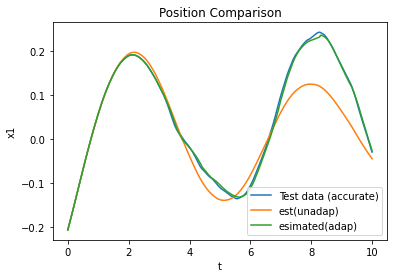

In [498]:
plt.figure()
plt.plot(T_test[:-1],x_cor[:,0],label ='Test data (accurate)')
plt.plot(T_test[:],x_incor_est[:,0],label ='est(unadap)')
plt.plot(T_test,x_adap_est[:,0],label = 'esimated(adap)')
plt.xlabel('t')
plt.ylabel('x1')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_pos.jpg')

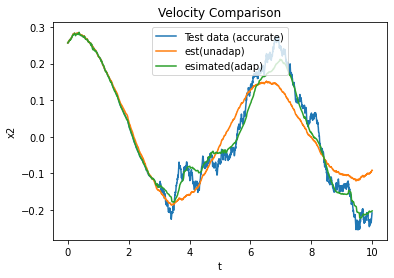

In [499]:
plt.figure()
plt.plot(T_test[:-1],x_cor[:,1],label ='Test data (accurate)')
plt.plot(T_test[:],x_incor_est[:,1],label ='est(unadap)')
plt.plot(T_test,x_adap_est[:,1],label = 'esimated(adap)')
plt.xlabel('t')
plt.ylabel('x2')
plt.title('Velocity Comparison')
plt.legend()
plt.savefig('adap_vel.jpg')

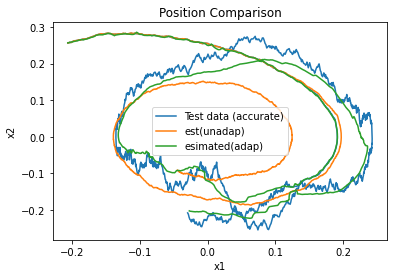

In [500]:
plt.figure()
plt.plot(x_cor[:,0],x_cor[:,1],label ='Test data (accurate)')
plt.plot(x_incor_est[:,0],x_incor_est[:,1],label ='est(unadap)')
plt.plot(x_adap_est[:,0],x_adap_est[:,1],label = 'esimated(adap)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Position Comparison')
plt.legend()
plt.savefig('adap_phase.jpg')

# Error Comparisons

In [503]:
error_dynamics_adap = np.sqrt(np.square(x_adap_est[:-1,:]-x_cor[:,:]).mean(axis=1))

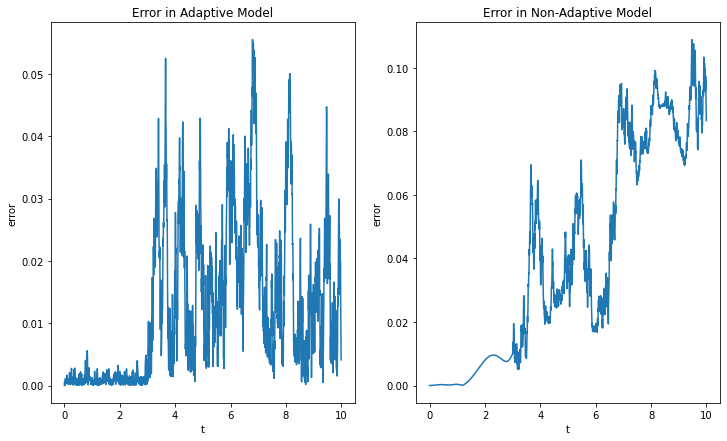

In [504]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Error in Adaptive Model")
axs[1].set_title("Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')


axs[0].plot(T_test[:-1],error_dynamics_adap)

axs[1].plot(T_test[:-1],error_dynamics)

plt.savefig('adap_error_comp.jpg')

## Norm evolutions

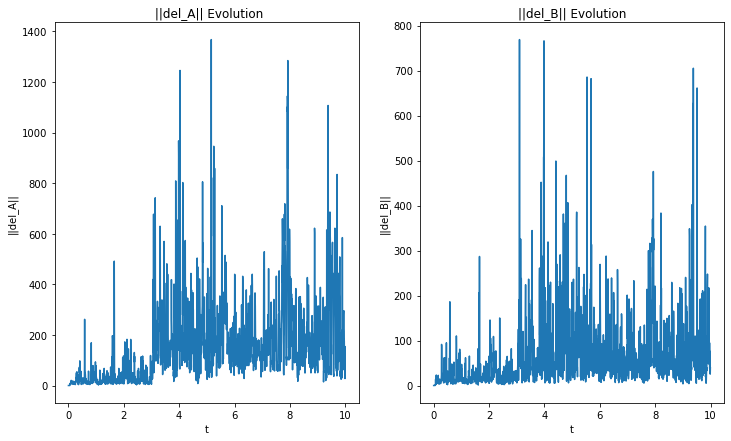

In [505]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title(" ||del_A|| Evolution")
axs[1].set_title("||del_B|| Evolution")

axs[0].set(xlabel = 't', ylabel = '||del_A||')
axs[1].set(xlabel = 't', ylabel = '||del_B||')


axs[0].plot(T_test[:-1],del_A_norm)

axs[1].plot(T_test[:-1],del_B_norm)

In [510]:
error_pos_adap = (x_adap_est[:-1,0]-x_cor[:,0])
error_pos_unadap = (x_incor_est[:-1,0]-x_cor[:,0])

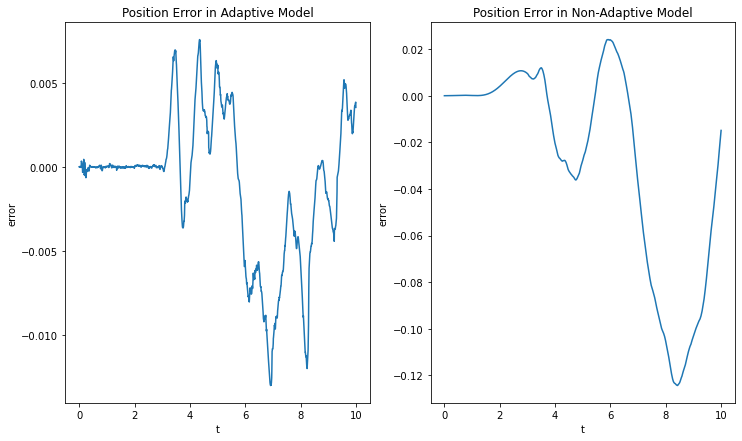

In [511]:
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Position Error in Adaptive Model")
axs[1].set_title("Position Error in Non-Adaptive Model")

axs[0].set(xlabel = 't', ylabel = 'error')
axs[1].set(xlabel = 't', ylabel = 'error')


axs[0].plot(T_test[:-1],error_pos_adap)

axs[1].plot(T_test[:-1],error_pos_unadap)

plt.savefig('adap_error_comp.jpg')

In [524]:
import pandas as pd

x_train = pd.DataFrame.from_dict({'x1':x_incor[:,0], 'y2':x_incor[:,1]})
x_actual = pd.DataFrame.from_dict({'x1':x_cor[:,0], 'y2':x_cor[:,1]})
x_unadap = pd.DataFrame.from_dict({'x1':x_incor_est[:,0], 'y2':x_incor_est[:,1]})
x_adap = pd.DataFrame.from_dict({'x1':x_adap_est[:,0], 'y2':x_adap_est[:,1]}) 


save_data = input("Save the data (y/n): ")

if  save_data == 'y':
    x_actual.to_csv('x_actual.csv')
    x_train.to_csv('x_train.csv')
    x_unadap.to_csv('x_unadap.csv')
    x_adap.to_csv('x_adap.csv')
    print('Data Saved')



Save the data (y/n):  y


Data Saved


In [519]:
T_test.shape

(2001,)